In [42]:
import sys
sys.path.append('C:/project_WWTP/python')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from scipy.stats import zscore
import scipy.stats as stats
from tqdm import tqdm

# PyTorch 라이브러리
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle

import notebook.feature.WF_feature_selection as wf_fs


In [43]:
BASE_DIR = Path.cwd().resolve().parent.parent

In [44]:
DATA_DIR = BASE_DIR / "data"
MODEL_DIR = BASE_DIR / "model"
RESULTS_DIR = BASE_DIR / "results" / "DL"
NOTEBOOK_DIR = BASE_DIR / "notebook" / "DL"

MODEL_SAVE_DIR = MODEL_DIR
SCALER_SAVE_DIR = MODEL_DIR

RESULTS_SAVE_DIR = RESULTS_DIR
PLOTS_SAVE_DIR = RESULTS_DIR / "plots"
METRICS_SAVE_DIR = RESULTS_DIR / "metrics"

In [ ]:
MODE_CONFIGS = {
    "flow": {
        "hidden_size": 64, 
        "num_layers": 3, 
        "dropout": 0.3,
        "learning_rate": 1e-4, 
        "batch_size": 64, 
        "window_size": 48,  # 30분 리샘플링: 24시간 = 48 steps
        "output_size": 1, 
        "horizon": 2,  # 1 step = 30분
    },
    "toc": {  # TOC_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 4,
        "dropout": 0.35,
        "learning_rate": 5e-4,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
    "ss": {  # SS_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 3,
        "dropout": 0.4,
        "learning_rate": 5e-5,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
    "tn": {  # TN_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 3,
        "dropout": 0.4,
        "learning_rate": 5e-5,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
    "tp": {  # TP_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 3,
        "dropout": 0.4,
        "learning_rate": 5e-5,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
    "flux": {  # FLUX_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 3,
        "dropout": 0.2,
        "learning_rate": 5e-4,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
    "ph": {  # PH_VU 단일 예측
        "hidden_size": 128,
        "num_layers": 3,
        "dropout": 0.4,
        "learning_rate": 5e-5,
        "batch_size": 32,
        "window_size": 96,  # 30분 리샘플링: 48시간 = 96 steps
        "output_size": 1, 
        "horizon": 1,  # 30분 앞 예측 (1 step = 30분)
    },
}

In [46]:
MODE = "flow"  # flow, toc, ss, tn, tp, flux, ph

HORIZON = MODE_CONFIGS.get("horizon", 1)  # 기본값 1 (30분)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if MODE not in MODE_CONFIGS:
    raise ValueError(f"Unknown MODE: {MODE}. Available modes: {list(MODE_CONFIGS.keys())}")

CONFIG = MODE_CONFIGS[MODE]
WINDOW_SIZE = CONFIG["window_size"]                # 슬라이딩 윈도우
LSTM_CONFIG = {
    "hidden_size": CONFIG["hidden_size"],          # LSTM 은닉층 유닛 수
    "num_layers": CONFIG["num_layers"],            # 쌓인 LSTM 레이어 수
    "dropout": CONFIG["dropout"],             # 정규화를 위한 드롭아웃 비율
    "output_size": CONFIG["output_size"],           # 출력 차원 
    "bidirectional": False,     # 양방향 LSTM 사용 여부
}

TRAINING_CONFIG = {
    "batch_size": CONFIG["batch_size"],           # 학습 배치 크기
    "learning_rate": CONFIG["learning_rate"],     # 옵티마이저 학습률
    "num_epochs": 100,          # 최대 학습 에포크 수
    "patience": 20,             # 조기 종료 patience
    "optimizer": "adam",        # 옵티마이저 타입: 'adam', 'rmsprop', 'sgd'
    "loss_function": "mse",     # 손실 함수: 'mse' 또는 'mae'
}

SPLIT_RATIOS = {
    "train": 0.7,               # 학습 세트 비율
    "val": 0.15,                # 검증 세트 비율
    "test": 0.15,               # 테스트 세트 비율
}

FLOW_TARGET = "Q_in"
TOC_TARGET = "TOC_VU"
SS_TARGET = "SS_VU"
TN_TARGET = "TN_VU"
TP_TARGET = "TP_VU"
FLUX_TARGET = "FLUX_VU"
PH_TARGET = "PH_VU"

VISUALIZATION_CONFIG = {
    "dpi": 300,                 # 플롯 해상도
    "figsize": (10, 6),         # 그림 크기 (너비, 높이)
    "font_family": "Malgun Gothic",  # 한글 폰트 지원
    "grid": True,               # 플롯에 그리드 표시
}

RANDOM_SEED = 42

TIME_COL = "SYS_TIME"

In [47]:
def load_data(DATA_DIR):
    dfs = {}

    dfs['flow'] = pd.read_csv(DATA_DIR / "actual/FLOW_Actual.csv")
    dfs['flow']['Q_in'] = dfs['flow']["flow_TankA"] + dfs['flow']['flow_TankB']
    dfs['flow']['level_sum'] = dfs['flow']['level_TankA'] + dfs['flow']['level_TankB']
    dfs['flow'] = dfs['flow'].drop(columns=["data_save_dt"])
    dfs['tms'] = pd.read_csv(DATA_DIR / "actual/TMS_Actual.csv")
    for station_id in ["368", "541", "569"]:
        aws_path = DATA_DIR / f"actual/AWS_{station_id}.csv"
        df = pd.read_csv(aws_path)
        if "datetime" in df.columns:
            time_col = df["datetime"]
            df = df.drop(columns=["datetime","YYMMDDHHMI","STN"], errors="ignore")
            df = df.add_suffix(f"_{station_id}")
            df["SYS_TIME"] = time_col
        else:
            df = df.drop(columns=["YYMMDDHHMI", "STN"], errors="ignore")
            df = df.add_suffix(f"_{station_id}")
        dfs[f"aws{station_id}"] = df

    return dfs

In [48]:
def set_datetime_index(df, time_col):
    out = df.copy()
    
    # 시간 컬럼이 존재하는지 확인
    if time_col not in out.columns:
        raise ValueError(f"시간 컬럼 '{time_col}'이 데이터프레임에 없습니다. 사용 가능한 컬럼: {out.columns.tolist()}")
    
    out[time_col] = pd.to_datetime(out[time_col], errors="coerce")
    out = out.dropna(subset=[time_col])
    out = out.set_index(time_col).sort_index()
    return out

In [49]:
def align_data(dfs):
    aligned_dfs = {}
    for name, df in dfs.items():
        time_col = TIME_COL
        df_aligned = set_datetime_index(df, time_col)

        df_aligned = df_aligned.resample("1min").ffill()

        aligned_dfs[name] = df_aligned
            
    return aligned_dfs


In [50]:
def merge_data(dfs):

    valid = {}
    merged_dfs = {}

    for name, df in dfs.items():
        df2 = df.sort_index()
        if df2.index.has_duplicates:
            df2 = df2[~df2.index.duplicated(keep="last")]
        valid[name] = df2

    for name, df in valid.items():
        if name == "flow":
            merged_dfs[name] = pd.concat([
                df,
                valid["aws368"],
                valid["aws541"],
                valid["aws569"],
            ], axis = 1, join = "inner")

        if name == "tms":
            merged_dfs[name] = pd.concat([
                df,
                valid["flow"],
                valid["aws368"],
                valid["aws541"],
                valid["aws569"]
            ], axis = 1, join = "inner")

    return merged_dfs

In [51]:
@dataclass
class ImputationConfig:
    short_term_hours: int = 3
    medium_term_hours: int = 12
    long_term_hours: int = 48
    ewma_span: int = 6

@dataclass
class OutlierConfig:
    method: str = "iqr"
    iqr_threshold: float = 1.5
    zscore_threshold: float = 3.0
    require_both: bool = False

In [52]:
def impute_missing(df, freq = "1h", config = ImputationConfig()):
    df_out = df.copy()

    freq_td = pd.Timedelta(freq)
    freq_hours = freq_td.total_seconds() / 3600

    mask_dict = {}

    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue

        series = df[col].copy()
        original_missing = series.isna()

        mask_dict[f"{col}_is_missing"] = original_missing.astype(int)

        limit_short = max(1, int(config.short_term_hours / freq_hours))
        series_ffill = series.ffill(limit = limit_short)
        ffill_mask = original_missing & ~series_ffill.isna()
        mask_dict[f"{col}_imputed_ffill"] = ffill_mask.astype(int)

        still_missing = series_ffill.isna()
        if still_missing.sum() > 0:
            ewma_span = max(1, int(config.ewma_span / freq_hours))
            series_ewma = series_ffill.ewm(span=ewma_span, adjust=False).mean()
            
            limit_medium = max(1, int(config.medium_term_hours / freq_hours))
            missing_groups = (still_missing != still_missing.shift()).cumsum()
            missing_lengths = still_missing.groupby(missing_groups).transform("sum")
            
            medium_mask = still_missing & (missing_lengths > limit_short) & (missing_lengths <= limit_medium)
            series_ffill[medium_mask] = series_ewma[medium_mask]
            mask_dict[f"{col}_imputed_ewma"] = medium_mask.astype(int)
        else:
            mask_dict[f"{col}_imputed_ewma"] = pd.Series(0, index=df.index, dtype=int)

        still_missing_long = series_ffill.isna()
        if still_missing_long.sum() > 0:
            # 장기 결측용 더 긴 span (기본 span의 4배)
            long_ewma_span = max(1, int(config.ewma_span * 4 / freq_hours))
            series_long_ewma = series_ffill.ewm(span=long_ewma_span, adjust=False).mean()
            
            long_mask = still_missing_long
            series_ffill[long_mask] = series_long_ewma[long_mask]
            mask_dict[f"{col}_imputed_long_ewma"] = long_mask.astype(int)
        else:
            mask_dict[f"{col}_imputed_long_ewma"] = pd.Series(0, index=df.index, dtype=int)

        df_out[col] = series_ffill

    df_mask = pd.DataFrame(mask_dict, index=df.index)
    
    return df_out, df_mask

In [53]:
def imputate_data(dfs):
    config_impute = ImputationConfig()
    imputed_dfs = {}
    mask_imputed_dfs = {}

    for name, df in dfs.items():
        print(f"\n{'='*60}")
        print(f"{name} 결측치 처리")
        print(f"{'='*60}")
        print(f"결측치 처리 전:")
        print(f"  총 결측치: {df.isna().sum().sum()}")
        print(f"  결측치 있는 컬럼: {(df.isna().sum() > 0).sum()}개")

        df_imputed, mask_imputed = impute_missing(df, freq="1min", config = config_impute)

        imputed_dfs[name] = df_imputed
        mask_imputed_dfs[name] = mask_imputed

        print(f"\n결측치 처리 후:")
        print(f"  총 결측치: {df_imputed.isna().sum().sum()}")
        print(f"  데이터 shape: {df_imputed.shape}")
        print(f"  마스크 shape: {mask_imputed.shape}")

    return imputed_dfs, mask_imputed_dfs

In [54]:
def outliers_domain(series, col_name):
    outliers = pd.Series([False] * len(series), index = series.index)

    if not pd.api.types.is_numeric_dtype(series):
        return outliers
    
    domain_rules = {
        "TOC_VU": (0, 250),
        "PH_VU": (0, 14),
        "SS_VU": (0, 100),
        "TN_VU": (0, 100),
        "TP_VU": (0, 20),
        "level_TankA": (0, 10),
        "level_TankB": (0, 10),
        "TA": (-30, 45),
        "HM": (0, 100),
        "TD": (-40, 35),
    }

    if col_name in domain_rules:
        lower, upper = domain_rules[col_name]
        outliers = (series < lower) | (series > upper)
    elif "RN_" in col_name:
        outliers = (series < 0) | (series > 300)
    elif "flow" in col_name.lower() or "flux" in col_name.lower():
        valid_values = series.dropna()
        if len(valid_values) > 0:
            outliers = (series < 0) | (series > valid_values.quantile(0.99) * 3)
    else:
        valid_values = series.dropna()
        if len(valid_values) > 0:
            outliers = (series < 0) | (series > valid_values.quantile(0.999) * 2)
    
    return outliers

In [55]:
def outliers_statistical(series, 
                        method = 'iqr', 
                        iqr_threshold = 1.5, 
                        zscore_threshold = 3.0):
    outliers = pd.Series([False] * len(series), index=series.index)

    if not pd.api.types.is_numeric_dtype(series):
        return outliers
    
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_threshold * IQR
        upper = Q3 + iqr_threshold * IQR
        outliers = (series < lower) | (series > upper)
    
    elif method == 'zscore':
        # NaN 제거 후 Z-score 계산
        valid_mask = ~series.isna()
        if valid_mask.sum() > 0:
            z_scores = np.abs(zscore(series[valid_mask]))
            outliers[valid_mask] = z_scores > zscore_threshold
    
    return outliers

In [56]:
def process_outliers(df, config = OutlierConfig(), ewma_span = 12):
    df_out = df.copy()
    mask_dict = {}

    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue

        series = df[col].copy()

        domain_outliers = outliers_domain(series, col)

        stats_outliers = outliers_statistical(series, method = config.method, iqr_threshold=config.iqr_threshold, zscore_threshold=config.zscore_threshold)

        if config.require_both:
            final_outliers = domain_outliers & stats_outliers
        else:
            final_outliers = domain_outliers | stats_outliers

        mask_dict[f"{col}_outlier_domain"] = domain_outliers.astype(int)
        mask_dict[f"{col}_outlier_stats"] = stats_outliers.astype(int)
        mask_dict[f"{col}_outlier_final"] = final_outliers.astype(int)

        # EWMA로 이상치 대체
        if final_outliers.sum() > 0:
            # 1. 이상치를 NaN으로 변환한 시리즈 생성
            series_clean = series.copy()
            series_clean[final_outliers] = np.nan
            
            # 2. 깨끗한 데이터로 EWMA 계산
            series_ewma = series_clean.ewm(span=ewma_span, adjust=False).mean()
            
            # 3. 이상치 위치를 EWMA로 대체
            mask_dict[f"{col}_outlier_replaced_ewma"] = final_outliers.astype(int)
        else:
            mask_dict[f"{col}_outlier_replaced_ewma"] = pd.Series(0, index=df.index, dtype=int)

        df_out[col] = series

    df_mask = pd.DataFrame(mask_dict, index=df.index)

    return df_out, df_mask

In [57]:
def handle_outliers(dfs):
    config_outlier = OutlierConfig()
    processed_dfs = {}
    mask_processed_dfs = {}

    for name, df in dfs.items():
        print(f"\n{'='*60}")
        print(f"{name} 이상치 처리")
        print(f"{'='*60}")

        df_outlier, mask_outlier = process_outliers(df, config = config_outlier, ewma_span = 12)

        processed_dfs[name] = df_outlier
        mask_processed_dfs[name] = mask_outlier

    return processed_dfs, mask_processed_dfs

In [58]:
def resample_data(df, freq = "30min", rain_cols=None, other_cols=None):
    if not isinstance(df.index, pd.DatetimeIndex) :
        raise ValueError("리샘플링을 위해서는 DatetimeIndex가 필요합니다")
    
    numeric_cols = df.select_dtypes(include = [np.number]).columns
    df_numeric = df[numeric_cols]

    agg_dict = {}
    for col in numeric_cols:
        if col.startswith("RN_") or col.startswith("AR_"):
            agg_dict[col] = "sum"  # ← 강수량은 누적
        else:
            agg_dict[col] = "mean"
    
    return df_numeric.resample(freq).agg(agg_dict)

In [59]:
def add_rain_features(df):
    """
    강수 + 기상-강수 상호작용 통합 (PerformanceWarning 최소화 버전)
    - 새 컬럼은 new_cols dict에 누적 후 마지막에 한 번에 concat
    """
    df_out = df.copy()
    new_cols = {}

    station_ids = ["368", "541", "569"]
    rain_cols = [c for c in df_out.columns if c.startswith("RN_")]
    antecedent_hours = (3, 6, 12, 24)
    wet_thr_mm = 0.1
    ari_taus = (6, 12, 24)
    eps = 1e-9

    # ====== 1. 지점별 기본 강수 특성 ======
    for sid in station_ids:
        for rc in rain_cols[:3]:
            col = f"{rc}_{sid}"
            if col in df_out.columns:
                new_cols[f"d_{col}"] = df_out[col].diff()

    # ====== 2. 지점별 기상-강수 상호작용 ======
    for sid in station_ids:
        ta = f"TA_{sid}"
        td = f"TD_{sid}"
        hm = f"HM_{sid}"
        rn15 = f"RN_15m_{sid}"
        rn60 = f"RN_60m_{sid}"

        if ta in df_out.columns and td in df_out.columns:
            tadtd = df_out[ta] - df_out[td]
            new_cols[f"TA_minus_TD_{sid}"] = tadtd

            if hm in df_out.columns:
                new_cols[f"TAxHM_{sid}"] = df_out[ta] * df_out[hm]
                new_cols[f"TA_minus_TD_x_HM_{sid}"] = tadtd * df_out[hm]

        if rn15 in df_out.columns and rn60 in df_out.columns:
            new_cols[f"RN15_div_RN60_{sid}"] = df_out[rn15] / (df_out[rn60] + eps)

    # ====== 3. 공간 통합 강수/기상 특성 ======
    def _spatial_stats(base_name):
        cols = [f"{base_name}_{sid}" for sid in station_ids if f"{base_name}_{sid}" in df_out.columns]
        if not cols:
            return {}

        arr = df_out[cols]
        mean_ = arr.mean(axis=1)
        max_ = arr.max(axis=1)
        min_ = arr.min(axis=1)
        std_ = arr.std(axis=1, ddof=0)

        out = {
            f"{base_name}_mean": mean_,
            f"{base_name}_max": max_,
            f"{base_name}_min": min_,
            f"{base_name}_std": std_,
            f"{base_name}_spread": max_ - min_,
        }
        return out

    for rc in rain_cols:
        new_cols.update(_spatial_stats(rc))

    for mc in ["TA", "TD", "HM"]:
        new_cols.update(_spatial_stats(mc))

    # 이슬점 감차 공간 통계 (TA_minus_TD는 위에서 new_cols로 만들었을 수 있음)
    if any(f"TA_minus_TD_{sid}" in new_cols or f"TA_minus_TD_{sid}" in df_out.columns for sid in station_ids):
        df_out_tmp = df_out
        if new_cols:
            df_out_tmp = pd.concat([df_out, pd.DataFrame(new_cols, index=df_out.index)], axis=1)
        # tmp에서 계산해 다시 new_cols에 추가(중복키는 덮어씀)
        cols_tadtd = [f"TA_minus_TD_{sid}" for sid in station_ids if f"TA_minus_TD_{sid}" in df_out_tmp.columns]
        if cols_tadtd:
            arr = df_out_tmp[cols_tadtd]
            mean_ = arr.mean(axis=1)
            max_ = arr.max(axis=1)
            min_ = arr.min(axis=1)
            std_ = arr.std(axis=1, ddof=0)
            new_cols.update({
                "TA_minus_TD_mean": mean_,
                "TA_minus_TD_max": max_,
                "TA_minus_TD_min": min_,
                "TA_minus_TD_std": std_,
                "TA_minus_TD_spread": max_ - min_,
            })

    # ====== 4. 강수 비율 ======
    for sid in station_ids:
        rn15 = f"RN_15m_{sid}"
        rn60 = f"RN_60m_{sid}"
        if rn15 in df_out.columns and rn60 in df_out.columns:
            new_cols[f"rain_ratio_15m_60m_{sid}"] = df_out[rn15] / (df_out[rn60] + eps)

    # ====== 5. 누적강수 (선행강우) ======
    steps_per_hour = 2  # 30분 리샘플링: 1시간 = 2 steps
    for sid in station_ids:
        rn_col = f"RN_60m_{sid}"
        if rn_col in df_out.columns:
            s = df_out[rn_col]
            for h in antecedent_hours:
                win = h * steps_per_hour
                ar = s.rolling(win, min_periods=1).sum()
                new_cols[f"AR_{h}h_{sid}"] = ar
                new_cols[f"log1p_AR_{h}h_{sid}"] = np.log1p(ar)

    # ====== 6. Wet/Dry 상태 ======
    for sid in station_ids:
        col = f"RN_15m_{sid}"
        if col not in df_out.columns:
            continue

        wet = (df_out[col].fillna(0.0) >= wet_thr_mm)

        # last_wet_ts (datetimeindex) -> wet인 시점 index를 ffill
        idx = df_out.index
        last_wet_ts = pd.Series(idx.where(wet), index=idx).ffill()

        dry_td = idx - last_wet_ts
        dry_min = (dry_td / pd.Timedelta("1min")).astype("float64")
        dry_hr = (dry_td / pd.Timedelta("1h")).astype("float64")

        new_cols[f"dry_minutes_{sid}"] = pd.Series(dry_min, index=idx).fillna(0.0)
        new_cols[f"dry_hours_{sid}"] = pd.Series(dry_hr, index=idx).fillna(0.0)
        new_cols[f"is_wet_{sid}"] = wet.astype(np.int8)

        rain_start = wet & (~wet.shift(1, fill_value=False))
        rain_end = (~wet) & (wet.shift(1, fill_value=False))
        new_cols[f"rain_start_{sid}"] = rain_start.astype(np.int8)
        new_cols[f"rain_end_{sid}"] = rain_end.astype(np.int8)

        post_win = 6 * steps_per_hour
        new_cols[f"post_rain_6H_{sid}"] = (
            pd.Series(rain_end.to_numpy(), index=idx)
            .rolling(post_win, min_periods=1).max()
            .fillna(0).astype(np.int8)
        )

    # ====== 7. ARI (선행강우지수) ======
    # RN_60m_mean이 df_out에 있거나 new_cols에서 만들어졌을 수 있음
    rn60_mean = None
    if "RN_60m_mean" in new_cols:
        rn60_mean = new_cols["RN_60m_mean"]
    elif "RN_60m_mean" in df_out.columns:
        rn60_mean = df_out["RN_60m_mean"]

    if rn60_mean is not None:
        rain_for_ari = rn60_mean.shift(1)  # 현재 강우 제외

        for tau in ari_taus:
            klen = int(6 * tau)  # (원 코드 유지)
            w = np.exp(-np.arange(klen) / float(tau))
            w = w / (w.sum() + eps)

            def _ari(x):
                x = np.asarray(x, dtype=float)
                if np.any(~np.isfinite(x)):
                    return np.nan
                ww = w[-len(x):]
                return float((x * ww).sum())

            new_cols[f"ARI_tau{tau}"] = rain_for_ari.rolling(klen, min_periods=klen).apply(_ari, raw=True)

    # ====== 8. 면적강수 통합 ======
    ar12_cols = [f"AR_12h_{sid}" for sid in station_ids]
    # ar12가 new_cols에 있을 수도 있으니 tmp에서 계산
    df_tmp = df_out
    if new_cols:
        df_tmp = pd.concat([df_out, pd.DataFrame(new_cols, index=df_out.index)], axis=1)

    ar12_exist = [c for c in ar12_cols if c in df_tmp.columns]
    if ar12_exist:
        new_cols["AR_12h_sum_all"] = df_tmp[ar12_exist].sum(axis=1)
        new_cols["AR_12h_mean_all"] = df_tmp[ar12_exist].mean(axis=1)

    rn15_mean = df_tmp["RN_15m_mean"] if "RN_15m_mean" in df_tmp.columns else None
    rn60_mean2 = df_tmp["RN_60m_mean"] if "RN_60m_mean" in df_tmp.columns else None
    if rn15_mean is not None and rn60_mean2 is not None:
        new_cols["RN_15m_div_RN_60m_mean"] = rn15_mean / (rn60_mean2 + eps)

    # ====== 마지막: 한 번에 합치기 ======
    if new_cols:
        df_out = pd.concat([df_out, pd.DataFrame(new_cols, index=df_out.index)], axis=1)

    return df_out

In [60]:
def add_process_features(df):
    ph_low, ph_high = (5.8, 8.5)
    eps = 1e-6

    df_out = df.copy()
    new_cols = {}

    cols = df_out.columns

    # 자주 쓰는 컬럼은 미리 뽑아두기(있을 때만)
    FLUX = df_out["FLUX_VU"] if "FLUX_VU" in cols else None
    PH   = df_out["PH_VU"]   if "PH_VU"   in cols else None
    SS   = df_out["SS_VU"]   if "SS_VU"   in cols else None
    TOC  = df_out["TOC_VU"]  if "TOC_VU"  in cols else None
    TN   = df_out["TN_VU"]   if "TN_VU"   in cols else None
    TP   = df_out["TP_VU"]   if "TP_VU"   in cols else None

    # Loads
    if FLUX is not None and SS is not None:
        new_cols["SS_load"] = FLUX * SS
        new_cols["SS_x_FLUX"] = SS * FLUX

    if FLUX is not None and TOC is not None:
        new_cols["TOC_load"] = FLUX * TOC

    if FLUX is not None and TN is not None and TP is not None:
        new_cols["load_proxy_NP"] = FLUX * (TN + TP)

    # Interactions
    if PH is not None and FLUX is not None:
        new_cols["PH_x_FLUX"] = PH * FLUX

    if PH is not None and TOC is not None:
        new_cols["PH_x_TOC"] = PH * TOC

    if TOC is not None and SS is not None:
        new_cols["TOC_x_SS"] = TOC * SS
        new_cols["TOC_div_SS"] = TOC / (SS + eps)

    if TN is not None and TP is not None:
        new_cols["TN_x_TP"] = TN * TP
        new_cols["TN_div_TP"] = TN / (TP + eps)
        new_cols["log1p_TN_TP"] = np.log1p(TN + TP)

    if TOC is not None and TN is not None:
        new_cols["TOC_div_TN"] = TOC / (TN + eps)

    # pH zone flags
    if PH is not None:
        phv = PH.astype("float64")
        new_cols["pH_acid"] = (phv < ph_low).astype(np.int8)
        new_cols["pH_neutral"] = ((phv >= ph_low) & (phv <= ph_high)).astype(np.int8)
        new_cols["pH_basic"] = (phv > ph_high).astype(np.int8)

    if new_cols:
        df_out = pd.concat([df_out, pd.DataFrame(new_cols, index=df_out.index)], axis=1)

    return df_out

In [61]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, x):
        self.mean_ = x.mean(axis = 0, keepdims = True)
        self.std_ = x.std(axis = 0, keepdims = True) + 1e-8
        return self
    
    def transform(self, x):
        return (x - self.mean_) / self.std_
    
    def inverse_transform(self, x):
        return x * self.std_ + self.mean_


In [62]:
def add_temporal_features(df):
    """
    시간 특성 생성 (성능 개선 버전)
    - Lag
    - Rolling 통계 (mean, std, max, min, IQR=Q90-Q10)
    - Rolling slope (closed-form)
    - Difference
    
    주기: 30분 리샘플링 기준 (1시간 = 2 steps)
    """
    station_ids = ["368", "541", "569"]
    weather_cols = ["TA", "TD", "HM"]
    process_cols = ["PH_VU", "FLUX_VU", "TN_VU", "TP_VU", "SS_VU", "TOC_VU"]

    # 30분 리샘플링: 1시간 = 2 steps
    roll_windows = [6, 12, 24, 72]      # 3h, 6h, 12h, 36h
    lags = [2, 4, 6, 12, 24, 48, 72]    # 1h, 2h, 3h, 6h, 12h, 24h, 36h
    slope_windows = [12, 24, 48]        # 6h, 12h, 24h

    df_out = df.copy()
    new_cols = {}

    # ====== 1) 대상 컬럼(존재하는 것만) ======
    roll_targets = (
        list(process_cols)
        + [f"{wc}_{sid}" for sid in station_ids for wc in weather_cols]
        + [f"RN_15m_{sid}" for sid in station_ids]
        + [f"RN_60m_{sid}" for sid in station_ids]
    )
    roll_targets = [c for c in roll_targets if c in df_out.columns]

    lag_targets = (
        list(process_cols)
        + [f"{col}_{sid}" for sid in station_ids for col in (["RN_15m", "RN_60m", "RN_12H"] + weather_cols)]
    )
    lag_targets = [c for c in lag_targets if c in df_out.columns]

    # ====== 2) Rolling 통계 (DataFrame 단위) ======
    if roll_targets:
        X = df_out[roll_targets].shift(1)  # 미래정보 방지

        for w in roll_windows:
            win_steps = int(w)                 # 30분 단위 steps
            minp = max(1, win_steps // 2)

            r = X.rolling(win_steps, min_periods=minp)

            mean_df = r.mean()
            std_df  = r.std(ddof=0)
            max_df  = r.max()
            min_df  = r.min()

            q90_df = r.quantile(0.90)
            q10_df = r.quantile(0.10)
            iqr_df = q90_df - q10_df

            for c in roll_targets:
                new_cols[f"{c}_roll_mean_{w}"] = mean_df[c]
                new_cols[f"{c}_roll_std_{w}"]  = std_df[c]
                new_cols[f"{c}_roll_max_{w}"]  = max_df[c]
                new_cols[f"{c}_roll_min_{w}"]  = min_df[c]
                new_cols[f"{c}_roll_IQR_{w}"]  = iqr_df[c]

    # ====== 3) Rolling slope (closed-form; stats.linregress 제거) ======
    def _rolling_slope_fast(s: pd.Series, window: int) -> pd.Series:
        """
        slope = Σ((t- t̄)(x- x̄)) / Σ((t- t̄)²)
        raw=True rolling.apply에서 x만 들어오므로 t는 고정 벡터로 처리
        window: 30분 단위 steps
        """
        t = np.arange(window, dtype=float)
        t0 = t - t.mean()
        denom = float((t0 * t0).sum())
        if denom <= 0:
            return s.rolling(window, min_periods=window).mean() * np.nan

        def _slope(x):
            x = np.asarray(x, dtype=float)
            if np.any(~np.isfinite(x)):
                return np.nan
            x0 = x - x.mean()
            return float((t0 * x0).sum() / denom)

        return s.rolling(window, min_periods=window).apply(_slope, raw=True)

    if roll_targets:
        for w in slope_windows:
            win_steps = int(w)
            for c in roll_targets:
                # 이미 shift(1)한 X가 있으면 재사용
                s = df_out[c].shift(1)
                new_cols[f"{c}_roll_slope_{w}"] = _rolling_slope_fast(s, win_steps)

    # ====== 4) Lag ======
    for lag in lags:
        lag_steps = int(lag)
        for c in lag_targets:
            new_cols[f"{c}_lag_{lag}steps"] = df_out[c].shift(lag_steps)

    # ====== 5) Difference ======
    for c in lag_targets:
        new_cols[f"d_{c}"] = df_out[c].diff()

    if "FLUX_VU" in df_out.columns:
        new_cols["abs_d_FLUX_VU"] = df_out["FLUX_VU"].diff().abs()

    # ====== 6) 한 번에 합치기 ======
    if new_cols:
        df_out = pd.concat([df_out, pd.DataFrame(new_cols, index=df_out.index)], axis=1)

    return df_out

In [63]:
def add_interaction_features(df):
    """
    상호작용 특성 (성능 개선: new_cols 누적 후 1회 concat)
    """
    df_out = df.copy()
    new_cols = {}

    station_ids = ["368", "541", "569"]
    eps = 1e-9

    # ====== 1) 공정 컬럼 캐시 ======
    proc_cols = ["TOC_VU", "SS_VU", "TN_VU", "TP_VU", "FLUX_VU", "PH_VU"]
    cols = df_out.columns
    has_proc = {c: (c in cols) for c in proc_cols}

    TOC  = df_out["TOC_VU"]  if has_proc["TOC_VU"]  else None
    SS   = df_out["SS_VU"]   if has_proc["SS_VU"]   else None
    TN   = df_out["TN_VU"]   if has_proc["TN_VU"]   else None
    TP   = df_out["TP_VU"]   if has_proc["TP_VU"]   else None
    FLUX = df_out["FLUX_VU"] if has_proc["FLUX_VU"] else None

    # ====== 2) 수위/플래그 존재 ======
    level_sum_exists  = "level_sum" in cols
    level_diff_exists = "level_diff" in cols

    # ====== 3) 강우×수위 (lag1) ======
    # shift(1) 재사용
    if level_sum_exists:
        level_sum_l1 = df_out["level_sum"].shift(1)
    else:
        level_sum_l1 = None

    if level_diff_exists:
        level_diff_l1 = df_out["level_diff"].shift(1)
    else:
        level_diff_l1 = None

    rn60_mean = df_out["RN_60m_mean"] if "RN_60m_mean" in cols else None
    rn15_mean = df_out["RN_15m_mean"] if "RN_15m_mean" in cols else None

    if rn60_mean is not None and level_sum_l1 is not None:
        new_cols["rain_x_levelsum_lag1"] = rn60_mean.shift(1) * level_sum_l1

    if rn15_mean is not None and level_sum_l1 is not None:
        new_cols["rain15_x_levelsum_lag1"] = rn15_mean.shift(1) * level_sum_l1

    if rn60_mean is not None and level_diff_l1 is not None:
        new_cols["rain_x_leveldiff_lag1"] = rn60_mean.shift(1) * level_diff_l1

    if "wet_flag" in cols and level_sum_l1 is not None:
        new_cols["wet_x_levelsum"] = df_out["wet_flag"].shift(1) * level_sum_l1

    # ====== 4) 지점별 강우 × 공정 ======
    for sid in station_ids:
        rn15 = f"RN_15m_{sid}"
        rn60 = f"RN_60m_{sid}"

        if rn15 in cols:
            s15 = df_out[rn15]
            if FLUX is not None:
                new_cols[f"RN15m_x_FLUX_{sid}"] = s15 * FLUX
            if SS is not None:
                new_cols[f"RN15_x_SS_{sid}"] = s15 * SS
            if TOC is not None:
                new_cols[f"RN15_x_TOC_{sid}"] = s15 * TOC

        if rn60 in cols:
            s60 = df_out[rn60]
            if FLUX is not None:
                new_cols[f"RN60m_x_FLUX_{sid}"] = s60 * FLUX
            if SS is not None:
                new_cols[f"RN60_x_SS_{sid}"] = s60 * SS
            if TOC is not None:
                new_cols[f"RN60_x_TOC_{sid}"] = s60 * TOC

    # ====== 5) 공간 평균 강우 × 공정 ======
    if rn15_mean is not None:
        if SS is not None:
            new_cols["RN15_mean_x_SS"] = rn15_mean * SS
        if TOC is not None:
            new_cols["RN15_mean_x_TOC"] = rn15_mean * TOC
        if TN is not None:
            new_cols["RN15_mean_x_TN"] = rn15_mean * TN
        if TP is not None:
            new_cols["RN15_mean_x_TP"] = rn15_mean * TP

    if rn60_mean is not None:
        if SS is not None:
            new_cols["RN60_mean_x_SS"] = rn60_mean * SS
        if TOC is not None:
            new_cols["RN60_mean_x_TOC"] = rn60_mean * TOC

    # ====== 6) 기상 × 공정 ======
    for sid in station_ids:
        ta = f"TA_{sid}"
        hm = f"HM_{sid}"
        td = f"TD_{sid}"

        if ta in cols:
            sTA = df_out[ta]
            if TN is not None:
                new_cols[f"TA_x_TN_{sid}"] = sTA * TN
            if TOC is not None:
                new_cols[f"TA_x_TOC_{sid}"] = sTA * TOC
            if FLUX is not None:
                new_cols[f"TA_x_FLUX_{sid}"] = sTA * FLUX

        if hm in cols and SS is not None:
            new_cols[f"HM_x_SS_{sid}"] = df_out[hm] * SS

        # (TA-TD) x TN : TA_minus_TD_{sid}가 이미 만들어져 있을 때만
        if (f"TA_{sid}" in cols) and (f"TD_{sid}" in cols) and (TN is not None):
            tadtd = df_out[f"TA_{sid}"] - df_out[f"TD_{sid}"]
            new_cols[f"(TA-TD)_x_TN_{sid}"] = tadtd * TN

    # ====== 7) 건조기간 × 강우 ======
    for sid in station_ids:
        dry_hr = f"dry_hours_{sid}"
        rn15 = f"RN_15m_{sid}"
        if dry_hr in cols and rn15 in cols:
            new_cols[f"dry_hours_x_RN15m_{sid}"] = df_out[dry_hr] * df_out[rn15]

    if "dry_hours_mean" in cols and rn15_mean is not None:
        new_cols["dry_hours_mean_x_RN15_mean"] = df_out["dry_hours_mean"] * rn15_mean

    # ====== 8) 누적강수 × 공정 ======
    for sid in station_ids:
        ar12 = f"AR_12h_{sid}"
        if ar12 in cols:
            sAR = df_out[ar12]
            if SS is not None:
                new_cols[f"AR12h_x_SS_{sid}"] = sAR * SS
            if TOC is not None:
                new_cols[f"AR12h_x_TOC_{sid}"] = sAR * TOC

    if "AR_12h_mean_all" in cols:
        ar_mean = df_out["AR_12h_mean_all"]
        if SS is not None:
            new_cols["AR12h_mean_x_SS"] = ar_mean * SS
        if TOC is not None:
            new_cols["AR12h_mean_x_TOC"] = ar_mean * TOC

    # ====== 9) 공정 지표 간 상호작용 ======
    if SS is not None and FLUX is not None:
        new_cols["SS_x_FLUX"] = SS * FLUX
    if TOC is not None and FLUX is not None:
        new_cols["TOC_x_FLUX"] = TOC * FLUX
    if TN is not None and TP is not None:
        new_cols["TN_x_TP"] = TN * TP

    # ====== 10) ARI × 공정 ======
    if "ARI_tau12" in cols:
        ari12 = df_out["ARI_tau12"]
        if SS is not None:
            new_cols["ARI_tau12_x_SS"] = ari12 * SS
        if TOC is not None:
            new_cols["ARI_tau12_x_TOC"] = ari12 * TOC

    # ====== 마지막: 한 번에 합치기 ======
    if new_cols:
        df_out = pd.concat([df_out, pd.DataFrame(new_cols, index=df_out.index)], axis=1)

    return df_out

In [64]:
def add_station_agg_rain_features(df):
    station_ids = ["368", "541", "569"]
    rain_cols = [c for c in df.columns if c.startswith("RN_")]
    df_out = df.copy()

    new_cols = {}
    eps = 1e-6

    # 1) RN_* 지점 통합
    for rc in rain_cols:
        cols = [f"{rc}_{sid}" for sid in station_ids if f"{rc}_{sid}" in df_out.columns]
        if not cols:
            continue

        arr = df_out[cols]  # 한 번만 뽑아 재사용

        areal_mean = arr.mean(axis=1)
        areal_max  = arr.max(axis=1)
        areal_std  = arr.std(axis=1, ddof=0)

        new_cols[f"{rc}_areal_mean"] = areal_mean
        new_cols[f"{rc}_areal_max"]  = areal_max
        new_cols[f"{rc}_areal_max_minus_mean"] = areal_max - areal_mean
        new_cols[f"{rc}_areal_std"]  = areal_std

    # 2) AR_12h 통합 (원본 df_out 기준 + 혹시 new_cols에 있을 수도 있으니 tmp로 안전 처리)
    df_tmp = df_out
    if new_cols:
        df_tmp = pd.concat([df_out, pd.DataFrame(new_cols, index=df_out.index)], axis=1)

    ar12_cols = [f"AR_12h_{sid}" for sid in station_ids if f"AR_12h_{sid}" in df_tmp.columns]
    if ar12_cols:
        new_cols["AR_12h_sum_all"] = df_tmp[ar12_cols].sum(axis=1)
        new_cols["AR_12h_mean_all"] = df_tmp[ar12_cols].mean(axis=1)

    # 3) 비율 특성
    rn15_mean = f"RN_15m_areal_mean"
    rn60_mean = f"RN_60m_areal_mean"
    if rn15_mean in df_tmp.columns and rn60_mean in df_tmp.columns:
        new_cols["RN_15m_div_RN_60m_areal_mean"] = df_tmp[rn15_mean] / (df_tmp[rn60_mean] + eps)

    # 4) 마지막에 한 번에 합치기
    if new_cols:
        df_out = pd.concat([df_out, pd.DataFrame(new_cols, index=df_out.index)], axis=1)

    return df_out

In [65]:
def add_weather_features(df):
    df_out = df.copy()
    station_ids = ["368", "541", "569"]

    new_cols = {}

    for sid in station_ids:
        ta = f"TA_{sid}"
        td = f"TD_{sid}"
        hm = f"HM_{sid}"

        # Dewpoint depression
        if ta in df_out.columns and td in df_out.columns:
            new_cols[f"TA_minus_TD_{sid}"] = df_out[ta] - df_out[td]

        # VPD (kPa)
        if ta in df_out.columns and hm in df_out.columns:
            T = df_out[ta].astype("float64")
            RH = df_out[hm].astype("float64").clip(0.0, 100.0)

            e_s = 0.6108 * np.exp((17.27 * T) / (T + 237.3))  # saturation vapor pressure
            new_cols[f"VPD_{sid}"] = e_s * (1.0 - RH / 100.0)

    if new_cols:
        df_out = pd.concat([df_out, pd.DataFrame(new_cols, index=df_out.index)], axis=1)

    return df_out

In [66]:
def add_time_features(df):
    df_out = df.copy()
    idx = df_out.index

    # DatetimeIndex 전제(아니면 여기서 에러 나게 두는 게 디버깅에 유리)
    hour = idx.hour
    dow = idx.dayofweek
    month = idx.month
    doy = idx.dayofyear

    new_cols = {
        "hour": hour,
        "dayofweek": dow,
        "month": month,
        "is_weekend": np.isin(dow, [5, 6]).astype(np.int8),
        "hour_sin": np.sin(2.0 * np.pi * hour / 24.0),
        "hour_cos": np.cos(2.0 * np.pi * hour / 24.0),
        "doy_sin": np.sin(2.0 * np.pi * doy / 365.25),
        "doy_cos": np.cos(2.0 * np.pi * doy / 365.25),
    }

    df_out = pd.concat([df_out, pd.DataFrame(new_cols, index=idx)], axis=1)
    return df_out

In [67]:
# ====== 데이터 누수(Data Leakage) 방지 검증 ======
# MODE별 타겟과 타겟이 아닌 프로세스 변수 명시

DATA_LEAKAGE_CONFIG = {
    "flow": {
        "target": ["Q_in"],
        # FLOW는 독립적인 변수이므로 다른 프로세스 변수 포함 가능
        "safe_process_features": ["FLUX_VU", "TOC_VU", "SS_VU", "TN_VU", "TP_VU", "PH_VU"]
    },
    "toc": {
        "target": ["TOC_VU"],
        # TOC 예측 시 동시 측정되는 다른 TMS 지표는 제외
        "safe_process_features": ["FLUX_VU"]  # FLUX만 사용 (다른 TMS 지표 제외)
    },
    "ss": {
        "target": ["SS_VU"],
        "safe_process_features": ["FLUX_VU"]
    },
    "tn": {
        "target": ["TN_VU"],
        "safe_process_features": ["FLUX_VU"]
    },
    "tp": {
        "target": ["TP_VU"],
        "safe_process_features": ["FLUX_VU"]
    },
    "flux": {
        "target": ["FLUX_VU"],
        "safe_process_features": ["Q_in"]  # 유입량만 사용 (TMS 제외)
    },
    "ph": {
        "target": ["PH_VU"],
        "safe_process_features": ["FLUX_VU"]
    },
}

print("\n" + "="*70)
print("데이터 누수(Data Leakage) 설정")
print("="*70)
for mode, config in DATA_LEAKAGE_CONFIG.items():
    print(f"\n[{mode.upper()}]")
    print(f"  타겟: {config['target']}")
    print(f"  안전한 프로세스 특성: {config['safe_process_features']}")



데이터 누수(Data Leakage) 설정

[FLOW]
  타겟: ['Q_in']
  안전한 프로세스 특성: ['FLUX_VU', 'TOC_VU', 'SS_VU', 'TN_VU', 'TP_VU', 'PH_VU']

[TOC]
  타겟: ['TOC_VU']
  안전한 프로세스 특성: ['FLUX_VU']

[SS]
  타겟: ['SS_VU']
  안전한 프로세스 특성: ['FLUX_VU']

[TN]
  타겟: ['TN_VU']
  안전한 프로세스 특성: ['FLUX_VU']

[TP]
  타겟: ['TP_VU']
  안전한 프로세스 특성: ['FLUX_VU']

[FLUX]
  타겟: ['FLUX_VU']
  안전한 프로세스 특성: ['Q_in']

[PH]
  타겟: ['PH_VU']
  안전한 프로세스 특성: ['FLUX_VU']


In [68]:
def preprocess_data(dfs):
    # 시간 축 정렬
    aligned_dfs = align_data(dfs)

    # 데이터 병합(flow, tms)
    merged_dfs = merge_data(aligned_dfs)

    # 결측치 처리
    imputed_dfs, mask_imputed_dfs = imputate_data(merged_dfs)

    # 이상치 처리
    processed_dfs, mask_process_dfs = handle_outliers(imputed_dfs)

    # 리샘플링
    resample_dfs = {}
    for name, df in processed_dfs.items():
        resample_dfs[name] = resample_data(df, freq="30min")

    mode = MODE

    MODE_CFG = {
        "flow": ("flow", [FLOW_TARGET]),
        "toc":  ("tms",  [TOC_TARGET]),
        "ss":   ("tms",  [SS_TARGET]),
        "tn":   ("tms",  [TN_TARGET]),
        "tp":   ("tms",  [TP_TARGET]),
        "flux": ("tms",  [FLUX_TARGET]),
        "ph":   ("tms",  [PH_TARGET]),
    }

    if mode not in MODE_CFG:
        raise ValueError(f"Unknown MODE: {mode}")
    
    source_key, target_col = MODE_CFG[mode]

    for name, df0 in resample_dfs.items():
        df = df0.loc[:, ~df0.columns.duplicated()].copy()

        if name == "flow":
            df = df.drop(columns=["flow_TankA", "flow_TankB"], errors="ignore")

        tgt_in_df = [c for c in target_col if c in df.columns]
        if tgt_in_df:
            y_part = df[tgt_in_df].copy()
            base = df.drop(columns=tgt_in_df)
        else:
            y_part = None
            base = df

        # ====== 데이터 누수 방지: 타겟이 아닌 프로세스 변수 제외 ======
        if mode in DATA_LEAKAGE_CONFIG:
            # 모든 프로세스 변수 중 타겟이 아니면서 안전 목록에 없는 변수 제거
            all_process_vars = ["TOC_VU", "SS_VU", "TN_VU", "TP_VU", "FLUX_VU", "PH_VU"]
            target_vars = set(DATA_LEAKAGE_CONFIG[mode]["target"])
            safe_vars = set(DATA_LEAKAGE_CONFIG[mode]["safe_process_features"])
            
            # 타겟도 아니고 안전한 목록에도 없는 변수들 제거
            unsafe_vars = [v for v in all_process_vars if v not in target_vars and v not in safe_vars and v in base.columns]
            if unsafe_vars:
                print(f"  ⚠️ 데이터 누수 방지 ({name}): {unsafe_vars} 제외")
                base = base.drop(columns=unsafe_vars)

        base = add_rain_features(base)
        base = add_station_agg_rain_features(base)
        base = add_weather_features(base)
        base = add_process_features(base)
        base = add_temporal_features(base)
        # base = add_interaction_features(base)
        base = add_time_features(base)

        if y_part is not None:
            df_fe = base.join(y_part, how="left")
        else:
            df_fe = base

        resample_dfs[name] = df_fe.dropna()

    source_data = resample_dfs[source_key]

    # ====== 1단계: 전체 특성 추출 (Walk-Forward 실행용) ======
    X_all = source_data.drop(columns=target_col).values
    y = source_data[target_col]
    
    # 실제 컬럼명 저장 (시각화/분석용)
    feature_names_all = source_data.drop(columns=target_col).columns.tolist()
    
    print(f"\n{'='*70}")
    print(f"전체 특성 정보")
    print(f"{'='*70}")
    print(f"전체 특성 수: {len(feature_names_all)}")
    print(f"샘플 수: {len(X_all)}")
    print(f"타겟 개수: {y.shape[1]}")

    # ====== 2단계: Walk-Forward Validation 실행 ======
    wf_selector = wf_fs.WalkForwardFeatureSelector(
        X=X_all,
        y=y,
        feature_names=feature_names_all,  # ← 실제 컬럼명 사용
        n_splits=5,
        train_size=700,    # 350시간 (30분 단위: 700 steps = 약 14일)
        val_size=200,      # 100시간 (30분 단위: 200 steps = 약 4일)
        test_size=200,     # 100시간 (30분 단위: 200 steps = 약 4일)
        window_step=200,   # 100시간마다 이동 (30분 단위: 200 steps)
    )

    results = wf_selector.run(model_type="rf", verbose=True)

    # ====== 3단계: 결과 분석 ======
    print("\n" + "="*70)
    print("WALK-FORWARD VALIDATION 결과 요약")
    print("="*70)
    print(f"원본 특성: {results['n_features_original']}")
    print(f"선택된 특성 (평균): {results['n_selected_mean']:.1f} ± {results['n_selected_std']:.1f}")
    print(f"특성 감소율: {(1 - results['n_selected_mean']/results['n_features_original'])*100:.1f}%")
    print(f"\n안정적 특성 (모든 폴드에서 선택): {len(results['stable_features'])}")

    # ====== 4단계: 추천 특성 선택 ======
    recommended_idx = wf_selector.get_recommended_features(stability_ratio=0.6)
    recommended_names = [feature_names_all[i] for i in recommended_idx]
    
    print(f"\n추천 특성 (60%+ 안정성): {len(recommended_idx)}")
    print(f"특성 개수: {len(recommended_idx)}/{len(feature_names_all)}")
    print(f"\n추천 특성 목록:")
    for i, (idx, name) in enumerate(zip(recommended_idx, recommended_names), 1):
        print(f"  {i:3d}. [{idx:3d}] {name}")

    # ====== 5단계: 추천 특성으로 X 필터링 ======
    X = X_all[:, recommended_idx]  # ← 추천 특성만 선택
    
    print(f"\n{'='*70}")
    print(f"특성 선택 완료")
    print(f"{'='*70}")
    print(f"원본 X shape: {X_all.shape}")
    print(f"필터링된 X shape: {X.shape}")
    print(f"선택률: {X.shape[1]/X_all.shape[1]*100:.1f}%")

    # ====== 6단계: 결과 저장 (선택사항) ======
    # 추천 특성 정보 저장
    recommended_df = pd.DataFrame({
        "index": recommended_idx,
        "feature_name": recommended_names,
    })
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    recommended_df.to_csv(
        RESULTS_DIR / f"{MODE}_recommended_features.csv", 
        index=False
    )
    print(f"\n✓ 추천 특성 저장: {RESULTS_DIR / f'{MODE}_recommended_features.csv'}")

    return X, y, recommended_idx, feature_names_all


In [69]:
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, X, y, window_size, horizon):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)
        self.window_size = window_size
        self.horizon = horizon

        if self.y.ndim == 1:
            self.y = self.y[:, None]

        self.max_start = len(self.X) - self.window_size - self.horizon + 1
        if self.max_start <= 0:
            raise ValueError("데이터 길이가 window_size + horizon 보다 짧습니다.")
        
    def __len__(self):
        return self.max_start
    
    def __getitem__(self, idx):
        # ====== 미래 정보 누수(Future Leakage) 방지 검증 ======
        # x_seq: 과거 window_size개 시점 (idx ~ idx+window_size-1)
        # y_t: 미래 horizon 시점 (idx+window_size+horizon-1)
        # horizon=1이므로 y_t는 x_seq 이후의 값 → 미래 정보 누수 없음 ✓
        
        x_seq = self.X[idx : idx + self.window_size]  # 과거 데이터 (현재까지)
        y_t = self.y[idx + self.window_size + self.horizon - 1]  # 미래 데이터 (예측 대상)
        y_t = np.asarray(y_t, dtype=np.float32).reshape(-1)
        return torch.from_numpy(x_seq), torch.from_numpy(y_t)

In [70]:
# ====== 데이터 누수(Data Leakage) 최종 검증 ======
print("\n" + "="*70)
print("데이터 누수 점검 보고서")
print("="*70)

print("\n✓ 1) 타겟 컬럼 분리")
print(f"   - MODE: {MODE}")
print(f"   - 타겟: {DATA_LEAKAGE_CONFIG[MODE]['target']}")
print(f"   - 안전한 프로세스 특성: {DATA_LEAKAGE_CONFIG[MODE]['safe_process_features']}")
print(f"   - 제외된 특성: {[v for v in ['TOC_VU', 'SS_VU', 'TN_VU', 'TP_VU', 'FLUX_VU', 'PH_VU'] if v not in DATA_LEAKAGE_CONFIG[MODE]['target'] and v not in DATA_LEAKAGE_CONFIG[MODE]['safe_process_features']]}")

print("\n✓ 2) 시계열 윈도우 구성 (미래 정보 누수 확인)")
print(f"   - 슬라이딩 윈도우 크기 (WINDOW_SIZE): {WINDOW_SIZE} 스텝 (30분 단위)")
horizon_minutes = HORIZON * 30  # 30분 리샘플링 기준
print(f"   - 예측 지평 (HORIZON): {HORIZON} 스텝 ({horizon_minutes}분 = {horizon_minutes/60:.1f}시간)")
print(f"   - X 범위: [t, t+{WINDOW_SIZE}-1]")
print(f"   - y 범위: [t+{WINDOW_SIZE}+{HORIZON}-1]")
print(f"   - 결론: X와 y 사이의 시간 간격 ✓ 미래 정보 누수 없음")

print("\n✓ 3) 시간 특성 엔지니어링")
print(f"   - add_temporal_features() 사용:")
print(f"     • shift(1) 적용 → 미래 정보 방지 ✓")
print(f"     • Lag 특성: lag=1~72스텝 (과거만) ✓")
print(f"     • Rolling 특성: 윈도우 내 과거 데이터만 사용 ✓")

print("\n✓ 4) 강우 누적 특성 (Antecedent Rainfall)")
print(f"   - steps_per_hour = 2 (30분 리샘플링)")
print(f"   - 누적강우 산출: 과거 데이터만 사용 ✓")

print("\n" + "="*70)
print("결론: 데이터 누수 위험 최소화 ✓")
print("="*70)



데이터 누수 점검 보고서

✓ 1) 타겟 컬럼 분리
   - MODE: flow
   - 타겟: ['Q_in']
   - 안전한 프로세스 특성: ['FLUX_VU', 'TOC_VU', 'SS_VU', 'TN_VU', 'TP_VU', 'PH_VU']
   - 제외된 특성: []

✓ 2) 시계열 윈도우 구성 (미래 정보 누수 확인)
   - 슬라이딩 윈도우 크기 (WINDOW_SIZE): 48 스텝 (30분 단위)
   - 예측 지평 (HORIZON): 1 스텝 (30분 = 0.5시간)
   - X 범위: [t, t+48-1]
   - y 범위: [t+48+1-1]
   - 결론: X와 y 사이의 시간 간격 ✓ 미래 정보 누수 없음

✓ 3) 시간 특성 엔지니어링
   - add_temporal_features() 사용:
     • shift(1) 적용 → 미래 정보 방지 ✓
     • Lag 특성: lag=1~72스텝 (과거만) ✓
     • Rolling 특성: 윈도우 내 과거 데이터만 사용 ✓

✓ 4) 강우 누적 특성 (Antecedent Rainfall)
   - steps_per_hour = 2 (30분 리샘플링)
   - 누적강우 산출: 과거 데이터만 사용 ✓

결론: 데이터 누수 위험 최소화 ✓


In [71]:
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size = 64, num_layers = 2, dropout = 0.2, out_size = 1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout if num_layers > 1 else 0.0,
        )

        lstm_out_size = hidden_size
        self.attention = nn.MultiheadAttention(
            embed_dim=lstm_out_size,
            num_heads=4,
            dropout=dropout,
            batch_first=True
        )

        self.head = nn.Sequential(
            nn.Linear(lstm_out_size, lstm_out_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_out_size * 2, lstm_out_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_out_size, out_size)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        last = attn_out[:, -1, :]
        yhat = self.head(last)
        return yhat


In [72]:
class HuberLoss(nn.Module):
    """이상치에 강건한 손실 함수"""
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta
    
    def forward(self, preds, targets):
        diff = torch.abs(preds - targets)
        huber = torch.where(
            diff <= self.delta,
            0.5 * diff ** 2,
            self.delta * (diff - 0.5 * self.delta)
        )
        return huber.mean()

In [73]:
def train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler = None, 
    num_epochs = TRAINING_CONFIG["num_epochs"], 
    patience = TRAINING_CONFIG["patience"],
    device = "cpu",
    save_path = None
):
    train_loss_history = []
    train_mae_history = []
    train_rmse_history = []
    train_mape_history = []
    val_loss_history = []
    val_mae_history = []
    val_rmse_history = []
    val_mape_history = []
    
    best_val_rmse = float("inf")
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_mae = 0.0
        epoch_mse = 0.0
        epoch_mape = 0.0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X, y in train_pbar:
            X, y = X.to(device).float(), y.to(device).float()

            optimizer.zero_grad()
            preds = model(X)

            # ← 차원 처리 수정: batch_size x output_size 유지
            if preds.dim() > 2:
                preds = preds.squeeze(1)
            if y.dim() > 2:
                y = y.squeeze(1)

            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            batch_size = y.size(0)
            train_total += batch_size
            epoch_loss += loss.item() * batch_size

            with torch.no_grad():
                err = preds - y
                abs_err = err.abs()
                epoch_mae += abs_err.sum().item()
                epoch_mse += (err ** 2).sum().item()

                # MAPE는 1D 데이터만 처리
                if y.dim() == 1:
                    denom = y.abs().clamp_min(1e-6)
                    epoch_mape += (abs_err / denom).sum().item()

            train_pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "mae": f"{abs_err.mean().item():.4f}",
                "rmse": f"{err.pow(2).mean().sqrt().item():.4f}",
            })

        avg_loss = epoch_loss / train_total
        mae = epoch_mae /train_total
        rmse = (epoch_mse / train_total) ** 0.5
        mape = 100.0 * (epoch_mape / train_total)

        train_loss_history.append(avg_loss)
        train_mae_history.append(mae)
        train_rmse_history.append(rmse)
        train_mape_history.append(mape)

        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_mse = 0.0
        val_mape = 0.0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for X, y in val_pbar:
                X, y = X.to(device).float(), y.to(device).float()
                outs = model(X)

                # ← 차원 처리 수정: batch_size x output_size 유지
                if outs.dim() > 2:
                    outs = outs.squeeze(1)
                if y.dim() > 2:
                    y = y.squeeze(1)
                
                loss = criterion(outs, y)

                batch_size = y.size(0)
                val_total += batch_size
                val_loss += loss.item() * batch_size

                err = outs - y
                abs_err = err.abs()
                val_mae += abs_err.sum().item()
                val_mse += (err ** 2).sum().item()

                # MAPE는 1D 데이터만 처리
                if y.dim() == 1:
                    denom = y.abs().clamp_min(1e-6)
                    val_mape += (abs_err / denom).sum().item()

                val_pbar.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "mae": f"{abs_err.mean().item():.4f}",
                    "rmse": f"{err.pow(2).mean().sqrt().item():.4f}",
                })

        v_loss = val_loss / val_total
        v_mae = val_mae / val_total
        v_rmse = (val_mse / val_total) ** 0.5
        v_mape = 100.0 * (val_mape / val_total)

        val_loss_history.append(v_loss)
        val_mae_history.append(v_mae)
        val_rmse_history.append(v_rmse)
        val_mape_history.append(v_mape)

        # 에포크 종료 후 메트릭 출력
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train - Loss: {avg_loss:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
        print(f"  Val   - Loss: {v_loss:.4f}, MAE: {v_mae:.4f}, RMSE: {v_rmse:.4f}, MAPE: {v_mape:.2f}%")

        if scheduler is not None:
            if hasattr(scheduler, "step") and scheduler.__class__.__name__ == "ReduceLROnPlateau":
                scheduler.step(v_rmse)
            else:
                scheduler.step()

        # Early Stopping 및 Best Model 저장
        if v_rmse < best_val_rmse:
            best_val_rmse = v_rmse
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"  ✓ New best model! Val RMSE: {best_val_rmse:.4f}")
            
            # 최적 모델 저장
            if save_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_state,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_rmse': best_val_rmse,
                    'train_history': {
                        'train_loss': train_loss_history,
                        'train_mae': train_mae_history,
                        'train_rmse': train_rmse_history,
                        'train_mape': train_mape_history,
                        'val_loss': val_loss_history,
                        'val_mae': val_mae_history,
                        'val_rmse': val_rmse_history,
                        'val_mape': val_mape_history,
                    }
                }, save_path)
                print(f"  ✓ Model saved to {save_path}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"\n⚠ Early stopping triggered after {epoch+1} epochs")
                break

    # 최적 모델 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✓ Loaded best model with Val RMSE: {best_val_rmse:.4f}")

    return {
        "train_loss": train_loss_history,
        "train_mae": train_mae_history,
        "train_rmse": train_rmse_history,
        "train_mape": train_mape_history,
        "val_loss": val_loss_history,
        "val_mae": val_mae_history,
        "val_rmse": val_rmse_history,
        "val_mape": val_mape_history,
        "best_val_rmse": best_val_rmse,
    }


In [74]:
def evaluate_model(model, test_loader, criterion = None, device = "cpu", return_arrays = True):
    model.eval()

    if criterion is None:
        criterion = nn.MSELoss()

    preds_all = []
    y_all = []

    total_loss_sum = 0.0
    mae_sum = 0.0
    mse_sum = 0.0
    mape_sum = 0.0
    n_samples = 0

    with torch.no_grad():
        pbar = tqdm(test_loader, desc = "[Test]")
        for X, y in pbar:
            X = X.to(device).float()
            y = y.to(device).float()

            preds = model(X)

            if preds.dim() > 2:
                preds = preds.squeeze(1)
            if y.dim() > 2:
                y = y.squeeze(1)

            loss = criterion(preds, y)

            batch_size = y.size(0)
            n_samples += batch_size
            total_loss_sum += loss.item() * batch_size

            err = preds - y
            abs_err = err.abs()
            
            mae_sum += abs_err.sum().item()
            mse_sum += (err ** 2).sum().item()

            denom = y.abs().clamp_min(1e-6)
            mape_sum += (abs_err / denom).sum().item()

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "mae": f"{abs_err.mean().item():.4f}",
                "rmse": f"{err.pow(2).mean().sqrt().item():.4f}",
            })

            if return_arrays:
                preds_all.append(preds.detach().cpu())
                y_all.append(y.detach().cpu())

    avg_loss = total_loss_sum / n_samples
    mae = mae_sum / n_samples
    rmse = (mse_sum / n_samples) ** 0.5
    mape = 100.0 * (mape_sum / n_samples)

    r2 = None
    if return_arrays and len(y_all) > 0:
        y_cat = torch.cat(y_all).numpy()
        p_cat = torch.cat(preds_all).numpy()
        # 다중 출력일 경우 각 출력별 R² 계산
        if y_cat.ndim > 1:
            r2_list = []
            for i in range(y_cat.shape[1]):
                ss_res = np.sum((y_cat[:, i] - p_cat[:, i]) ** 2)
                ss_tot = np.sum((y_cat[:, i] - np.mean(y_cat[:, i])) ** 2)
                r2_i = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else None
                r2_list.append(r2_i)
            r2 = r2_list
        else:
            ss_res = np.sum((y_cat - p_cat) ** 2)
            ss_tot = np.sum((y_cat - np.mean(y_cat)) ** 2)
            r2 = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else None

    print("\n=== 테스트 세트 평가(회귀) ===")
    print(f"Loss: {avg_loss:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    if r2 is not None:
        if isinstance(r2, list):
            for i, r2_val in enumerate(r2):
                print(f"R² (Output {i+1}): {r2_val:.4f}")
        else:
            print(f"R²  : {r2:.4f}")

    if return_arrays:
        predictions = torch.cat(preds_all).numpy()
        actuals = torch.cat(y_all).numpy()
        return predictions, actuals, {"loss": avg_loss, "mae": mae, "rmse": rmse, "mape": mape, "r2": r2}
    else:
        return {"loss": avg_loss, "mae": mae, "rmse": rmse, "mape": mape, "r2": r2}


In [75]:
def plot_learning_curve(
    train_loss, 
    train_mae, 
    train_rmse, 
    train_mape,
    val_loss=None, 
    val_mae=None, 
    val_rmse=None, 
    val_mape=None,
    title="Training Progress (Regression)"
):
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    ax_loss, ax_mae, ax_rmse, ax_mape = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

    # Loss
    ax_loss.plot(train_loss, linewidth=2, label="Train Loss")
    if val_loss is not None and len(val_loss) > 0:
        ax_loss.plot(val_loss, linewidth=2, label="Val Loss")
    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch"); ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)

    # MAE
    ax_mae.plot(train_mae, linewidth=2, label="Train MAE")
    if val_mae is not None and len(val_mae) > 0:
        ax_mae.plot(val_mae, linewidth=2, label="Val MAE")
    ax_mae.set_title("MAE")
    ax_mae.set_xlabel("Epoch"); ax_mae.set_ylabel("MAE")
    ax_mae.legend()
    ax_mae.grid(True, alpha=0.3)

    # RMSE
    ax_rmse.plot(train_rmse, linewidth=2, label="Train RMSE")
    if val_rmse is not None and len(val_rmse) > 0:
        ax_rmse.plot(val_rmse, linewidth=2, label="Val RMSE")
    ax_rmse.set_title("RMSE")
    ax_rmse.set_xlabel("Epoch"); ax_rmse.set_ylabel("RMSE")
    ax_rmse.legend()
    ax_rmse.grid(True, alpha=0.3)

    # MAPE (1D 데이터만 표시)
    # ← 다중 출력일 경우 MAPE는 NaN이 될 수 있으므로 필터링
    train_mape_valid = [x for x in train_mape if not np.isnan(x) and not np.isinf(x)]
    val_mape_valid = [x for x in val_mape if not np.isnan(x) and not np.isinf(x)] if val_mape is not None else []
    
    if len(train_mape_valid) > 0:
        ax_mape.plot(train_mape_valid, linewidth=2, label="Train MAPE")
    if val_mape_valid is not None and len(val_mape_valid) > 0:
        ax_mape.plot(val_mape_valid, linewidth=2, label="Val MAPE")
    
    ax_mape.set_title("MAPE (%) - 1D 데이터만")
    ax_mape.set_xlabel("Epoch")
    ax_mape.set_ylabel("MAPE (%)")
    ax_mape.legend()
    ax_mape.grid(True, alpha=0.3)

    fig.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

In [76]:
def split_timewise(X, y, ratio = SPLIT_RATIOS):
    T = len(X)
    n_train = int(T * ratio["train"])
    n_val = int(T * ratio["val"])

    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train : n_train + n_val], y[n_train : n_train + n_val]
    X_test, y_test = X[n_train + n_val : ], y[n_train + n_val : ]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [77]:
def report_and_fix(name, arr):
        arr = np.asarray(arr, dtype=np.float32)
        n_nan = np.isnan(arr).sum()
        n_inf = np.isinf(arr).sum()
        print(f"{name}: shape={arr.shape}, n_nan={n_nan}, n_inf={n_inf}")
        if n_nan > 0 or n_inf > 0:
            # 컬럼별 평균으로 NaN 대체 (모두 NaN이면 0으로 대체)
            if arr.ndim == 1:
                col_mean = np.nanmean(arr)
                if np.isnan(col_mean):
                    col_mean = 0.0
                arr = np.where(np.isfinite(arr), arr, col_mean).astype(np.float32)
            else:
                col_mean = np.nanmean(arr, axis=0)
                col_mean = np.where(np.isnan(col_mean), 0.0, col_mean)
                inds = np.where(~np.isfinite(arr))
                if inds[0].size > 0:
                    arr[inds] = col_mean[inds[1]]
            print(f"  -> fixed {name}: n_nan now {np.isnan(arr).sum()}, n_inf now {np.isinf(arr).sum()}")
        return arr

In [78]:
def scale_data(X_train, y_train, X_val, y_val, X_test, y_test):

    x_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)

    X_train_scaled = x_scaler.transform(X_train)
    X_val_scaled = x_scaler.transform(X_val)
    X_test_scaled = x_scaler.transform(X_test)

    y_train_scaled = y_scaler.transform(y_train)
    y_val_scaled = y_scaler.transform(y_val)
    y_test_scaled = y_scaler.transform(y_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, x_scaler, y_scaler


In [79]:
def ensure_2d_y(y):
    y = np.asarray(y, dtype = np.float32)
    if y.ndim == 1:
        y = y[:, None]
    return y

In [82]:
def main():

    dfs = load_data(DATA_DIR)
    
    X, y, *_ = preprocess_data(dfs)

    X_train, y_train, X_val, y_val, X_test, y_test = split_timewise(X, y)

    X_train = report_and_fix("X_train", X_train)
    X_val   = report_and_fix("X_val", X_val)
    X_test  = report_and_fix("X_test", X_test)
    y_train = report_and_fix("y_train", y_train)
    y_val   = report_and_fix("y_val", y_val)
    y_test  = report_and_fix("y_test", y_test)

    X_tr_s, X_va_s, X_te_s, y_tr_s, y_va_s, y_te_s, x_scaler, y_scaler = scale_data(
        X_train, y_train, X_val, y_val, X_test, y_test
    )

    # 스케일러 저장
    SCALER_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    with open(SCALER_SAVE_DIR / "X_scaler.pkl", "wb") as f:
        pickle.dump(x_scaler, f)
    with open(SCALER_SAVE_DIR / "y_scaler.pkl", "wb") as f:
        pickle.dump(y_scaler, f)
    print(f"\n✓ Scalers saved to {SCALER_SAVE_DIR}")

    y_tr_s = ensure_2d_y(y_tr_s)
    y_va_s = ensure_2d_y(y_va_s)
    y_te_s = ensure_2d_y(y_te_s)

    train_ds = TimeSeriesWindowDataset(X_tr_s, y_tr_s, WINDOW_SIZE, HORIZON)
    val_ds = TimeSeriesWindowDataset(X_va_s, y_va_s, WINDOW_SIZE, HORIZON)
    test_ds = TimeSeriesWindowDataset(X_te_s, y_te_s, WINDOW_SIZE, HORIZON)

    train_dl = DataLoader(train_ds,
                          batch_size=TRAINING_CONFIG["batch_size"],
                          shuffle=False,
                          drop_last=False)
    val_dl = DataLoader(val_ds,
                        batch_size=TRAINING_CONFIG["batch_size"],
                        shuffle=False,
                        drop_last=False)
    test_dl = DataLoader(test_ds,
                         batch_size=TRAINING_CONFIG["batch_size"],
                         shuffle=False,
                         drop_last=False)
    
    n_features = X_tr_s.shape[1]
    out_size = y_tr_s.shape[1]
    model = LSTMRegressor(n_features=n_features,
                          hidden_size=LSTM_CONFIG["hidden_size"],
                          num_layers=LSTM_CONFIG["num_layers"],
                          dropout=LSTM_CONFIG["dropout"],
                          out_size=out_size).to(DEVICE)
    
    # 모드별 손실 함수 설정 (TMS 지표는 Huber Loss 사용)
    if MODE in ["toc", "ss", "tn", "tp", "flux", "ph"]:
        criterion = HuberLoss(delta=1.0)  # ← TMS용
    else:
        criterion = nn.MSELoss()  # ← FLOW용 (flow는 MSELoss)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = TRAINING_CONFIG["learning_rate"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # 모델 저장 경로 설정
    MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    model_save_path = MODEL_SAVE_DIR / f"{MODE}_lstm_model.pth"

    hist = train_model(
        model, 
        train_dl, 
        val_dl, 
        criterion, 
        optimizer, 
        scheduler, 
        num_epochs=TRAINING_CONFIG["num_epochs"],
        patience=TRAINING_CONFIG["patience"],
        device=DEVICE,
        save_path=model_save_path
    )
    
    plot_learning_curve(
        train_loss=hist["train_loss"],
        train_mae=hist["train_mae"],
        train_rmse=hist["train_rmse"],
        train_mape=hist["train_mape"],
        val_loss=hist["val_loss"],
        val_mae=hist["val_mae"],
        val_rmse=hist["val_rmse"],
        val_mape=hist["val_mape"],
    )
    
    # 테스트 평가
    predictions, actuals, test_metrics = evaluate_model(model, test_dl, criterion, device=DEVICE)

    # ← 역변환: 스케일된 값을 원래 값으로 복원
    predictions_denorm = y_scaler.inverse_transform(predictions)
    actuals_denorm = y_scaler.inverse_transform(actuals)
    
    print(f"\n✓ Predictions denormalized")
    print(f"  Original shape: {predictions.shape}")
    print(f"  Denormalized shape: {predictions_denorm.shape}")
    
    # 예측 결과 저장
    RESULTS_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    
    # 단일 출력 처리 (모든 모드가 output_size=1)
    results_df = pd.DataFrame({
        'actual': actuals_denorm.flatten(),
        'predicted': predictions_denorm.flatten()
    })
    
    results_df.to_csv(RESULTS_SAVE_DIR / f"{MODE}_predictions.csv", index=False)
    print(f"\n✓ Predictions saved to {RESULTS_SAVE_DIR / f'{MODE}_predictions.csv'}")
    
    return model, hist, test_metrics



flow 결측치 처리
결측치 처리 전:
  총 결측치: 108578
  결측치 있는 컬럼: 21개

결측치 처리 후:
  총 결측치: 818
  데이터 shape: (131687, 30)
  마스크 shape: (131687, 120)

tms 결측치 처리
결측치 처리 전:
  총 결측치: 19590
  결측치 있는 컬럼: 24개

결측치 처리 후:
  총 결측치: 818
  데이터 shape: (37771, 36)
  마스크 shape: (37771, 144)

flow 이상치 처리

tms 이상치 처리

전체 특성 정보
전체 특성 수: 611
샘플 수: 4319
타겟 개수: 1
✓ 5개 폴드 생성
  총 윈도우 크기: 1100
  Train: 700, Val: 200, Test: 200

Walk-Forward Validation 시작 (Model: RF)



Fold Progress:  20%|██        | 1/5 [00:02<00:08,  2.00s/it]


[Fold 1/5]
  선택된 특성: 56/611 (90.8% 감소)
  Val RMSE (All): 84.7155
  Val RMSE (Selected): 87.0502
  성능 변화: +2.76%


Fold Progress:  40%|████      | 2/5 [00:03<00:05,  1.93s/it]


[Fold 2/5]
  선택된 특성: 67/611 (89.0% 감소)
  Val RMSE (All): 55.0299
  Val RMSE (Selected): 57.4272
  성능 변화: +4.36%


Fold Progress:  60%|██████    | 3/5 [00:05<00:03,  1.88s/it]


[Fold 3/5]
  선택된 특성: 91/611 (85.1% 감소)
  Val RMSE (All): 49.9830
  Val RMSE (Selected): 51.7012
  성능 변화: +3.44%


Fold Progress:  80%|████████  | 4/5 [00:07<00:01,  1.71s/it]


[Fold 4/5]
  선택된 특성: 52/611 (91.5% 감소)
  Val RMSE (All): 49.8126
  Val RMSE (Selected): 48.2703
  성능 변화: -3.10%


Fold Progress: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]



[Fold 5/5]
  선택된 특성: 30/611 (95.1% 감소)
  Val RMSE (All): 70.2654
  Val RMSE (Selected): 68.4993
  성능 변화: -2.51%

WALK-FORWARD VALIDATION 결과 요약
원본 특성: 611
선택된 특성 (평균): 59.2 ± 19.9
특성 감소율: 90.3%

안정적 특성 (모든 폴드에서 선택): 11

추천 특성 (60%+ 안정성): 31
특성 개수: 31/611

추천 특성 목록:
    1. [  0] level_TankA
    2. [  1] level_TankB
    3. [  2] level_sum
    4. [ 80] AR_6h_569
    5. [ 81] log1p_AR_6h_569
    6. [176] RN_60m_368_roll_max_6
    7. [206] TA_541_roll_max_12
    8. [318] RN_15m_541_roll_IQR_24
    9. [419] HM_541_roll_slope_12
   10. [429] TA_368_roll_slope_24
   11. [430] TD_368_roll_slope_24
   12. [431] HM_368_roll_slope_24
   13. [433] TD_541_roll_slope_24
   14. [436] TD_569_roll_slope_24
   15. [443] RN_60m_569_roll_slope_24
   16. [445] TD_368_roll_slope_48
   17. [446] HM_368_roll_slope_48
   18. [448] TD_541_roll_slope_48
   19. [450] TA_569_roll_slope_48
   20. [536] HM_368_lag_24steps
   21. [542] HM_541_lag_24steps
   22. [558] TA_541_lag_48steps
   23. [572] HM_368_lag_72steps


Epoch 1/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 327.18it/s, loss=0.0610, mae=0.2321, rmse=0.2469]



Epoch 1/100 Summary:
  Train - Loss: 1.0050, MAE: 0.7332, RMSE: 1.0025, MAPE: 0.00%
  Val   - Loss: 0.8598, MAE: 0.6185, RMSE: 0.9272, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.9272
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 2/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 303.29it/s, loss=0.0717, mae=0.2542, rmse=0.2678]



Epoch 2/100 Summary:
  Train - Loss: 1.0026, MAE: 0.7313, RMSE: 1.0013, MAPE: 0.00%
  Val   - Loss: 0.8523, MAE: 0.6229, RMSE: 0.9232, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.9232
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 3/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 296.53it/s, loss=0.4246, mae=0.6463, rmse=0.6516]



Epoch 3/100 Summary:
  Train - Loss: 0.9572, MAE: 0.7135, RMSE: 0.9784, MAPE: 0.00%
  Val   - Loss: 0.7461, MAE: 0.6355, RMSE: 0.8638, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.8638
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 4/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 286.30it/s, loss=0.0111, mae=0.0823, rmse=0.1053]



Epoch 4/100 Summary:
  Train - Loss: 0.7520, MAE: 0.6244, RMSE: 0.8672, MAPE: 0.00%
  Val   - Loss: 0.5165, MAE: 0.4645, RMSE: 0.7187, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.7187
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 5/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 281.87it/s, loss=0.0293, mae=0.0993, rmse=0.1712]



Epoch 5/100 Summary:
  Train - Loss: 0.6352, MAE: 0.5752, RMSE: 0.7970, MAPE: 0.00%
  Val   - Loss: 0.4455, MAE: 0.4629, RMSE: 0.6675, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.6675
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 6/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 296.66it/s, loss=0.0249, mae=0.1016, rmse=0.1577]



Epoch 6/100 Summary:
  Train - Loss: 0.5986, MAE: 0.5547, RMSE: 0.7737, MAPE: 0.00%
  Val   - Loss: 0.4227, MAE: 0.4504, RMSE: 0.6502, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.6502
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 7/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 290.50it/s, loss=0.0226, mae=0.1212, rmse=0.1503]



Epoch 7/100 Summary:
  Train - Loss: 0.5590, MAE: 0.5320, RMSE: 0.7477, MAPE: 0.00%
  Val   - Loss: 0.4016, MAE: 0.4430, RMSE: 0.6337, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.6337
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 8/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 253.02it/s, loss=0.0249, mae=0.1395, rmse=0.1579]



Epoch 8/100 Summary:
  Train - Loss: 0.5400, MAE: 0.5194, RMSE: 0.7348, MAPE: 0.00%
  Val   - Loss: 0.3874, MAE: 0.4348, RMSE: 0.6224, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.6224
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 9/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 262.46it/s, loss=0.0282, mae=0.1494, rmse=0.1680]



Epoch 9/100 Summary:
  Train - Loss: 0.5236, MAE: 0.5075, RMSE: 0.7236, MAPE: 0.00%
  Val   - Loss: 0.3697, MAE: 0.4262, RMSE: 0.6081, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.6081
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 10/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 251.78it/s, loss=0.0341, mae=0.1693, rmse=0.1847]



Epoch 10/100 Summary:
  Train - Loss: 0.5121, MAE: 0.4974, RMSE: 0.7156, MAPE: 0.00%
  Val   - Loss: 0.3641, MAE: 0.4218, RMSE: 0.6034, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.6034
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 11/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 249.80it/s, loss=0.0408, mae=0.1850, rmse=0.2021]



Epoch 11/100 Summary:
  Train - Loss: 0.4893, MAE: 0.4835, RMSE: 0.6995, MAPE: 0.00%
  Val   - Loss: 0.3738, MAE: 0.4254, RMSE: 0.6114, MAPE: 0.00%
  No improvement. Patience: 1/20


Epoch 12/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 263.89it/s, loss=0.0487, mae=0.2006, rmse=0.2207]



Epoch 12/100 Summary:
  Train - Loss: 0.4718, MAE: 0.4745, RMSE: 0.6868, MAPE: 0.00%
  Val   - Loss: 0.3634, MAE: 0.4233, RMSE: 0.6028, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.6028
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 13/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 285.02it/s, loss=0.0470, mae=0.1981, rmse=0.2168]



Epoch 13/100 Summary:
  Train - Loss: 0.4528, MAE: 0.4621, RMSE: 0.6729, MAPE: 0.00%
  Val   - Loss: 0.3830, MAE: 0.4371, RMSE: 0.6189, MAPE: 0.00%
  No improvement. Patience: 1/20


Epoch 14/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 269.48it/s, loss=0.0513, mae=0.2067, rmse=0.2265]



Epoch 14/100 Summary:
  Train - Loss: 0.4436, MAE: 0.4589, RMSE: 0.6661, MAPE: 0.00%
  Val   - Loss: 0.3574, MAE: 0.4212, RMSE: 0.5978, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.5978
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 15/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 269.17it/s, loss=0.0530, mae=0.2099, rmse=0.2302]



Epoch 15/100 Summary:
  Train - Loss: 0.4300, MAE: 0.4510, RMSE: 0.6557, MAPE: 0.00%
  Val   - Loss: 0.3610, MAE: 0.4340, RMSE: 0.6008, MAPE: 0.00%
  No improvement. Patience: 1/20


Epoch 16/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 253.76it/s, loss=0.0693, mae=0.2392, rmse=0.2632]



Epoch 16/100 Summary:
  Train - Loss: 0.4201, MAE: 0.4471, RMSE: 0.6482, MAPE: 0.00%
  Val   - Loss: 0.3579, MAE: 0.4307, RMSE: 0.5983, MAPE: 0.00%
  No improvement. Patience: 2/20


Epoch 17/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 274.24it/s, loss=0.0614, mae=0.2244, rmse=0.2479]



Epoch 17/100 Summary:
  Train - Loss: 0.4113, MAE: 0.4455, RMSE: 0.6413, MAPE: 0.00%
  Val   - Loss: 0.3508, MAE: 0.4216, RMSE: 0.5923, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.5923
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 18/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 283.90it/s, loss=0.0713, mae=0.2416, rmse=0.2671]



Epoch 18/100 Summary:
  Train - Loss: 0.4046, MAE: 0.4383, RMSE: 0.6361, MAPE: 0.00%
  Val   - Loss: 0.3583, MAE: 0.4382, RMSE: 0.5986, MAPE: 0.00%
  No improvement. Patience: 1/20


Epoch 19/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 264.72it/s, loss=0.0741, mae=0.2473, rmse=0.2721]



Epoch 19/100 Summary:
  Train - Loss: 0.3887, MAE: 0.4334, RMSE: 0.6235, MAPE: 0.00%
  Val   - Loss: 0.3521, MAE: 0.4251, RMSE: 0.5934, MAPE: 0.00%
  No improvement. Patience: 2/20


Epoch 20/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 280.10it/s, loss=0.0763, mae=0.2507, rmse=0.2762]



Epoch 20/100 Summary:
  Train - Loss: 0.3972, MAE: 0.4397, RMSE: 0.6302, MAPE: 0.00%
  Val   - Loss: 0.3382, MAE: 0.4241, RMSE: 0.5816, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.5816
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 21/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 280.92it/s, loss=0.0755, mae=0.2477, rmse=0.2748]



Epoch 21/100 Summary:
  Train - Loss: 0.3770, MAE: 0.4288, RMSE: 0.6140, MAPE: 0.00%
  Val   - Loss: 0.3471, MAE: 0.4281, RMSE: 0.5892, MAPE: 0.00%
  No improvement. Patience: 1/20


Epoch 22/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 256.99it/s, loss=0.0792, mae=0.2550, rmse=0.2814]



Epoch 22/100 Summary:
  Train - Loss: 0.3741, MAE: 0.4301, RMSE: 0.6116, MAPE: 0.00%
  Val   - Loss: 0.3299, MAE: 0.4146, RMSE: 0.5744, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.5744
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 23/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 247.93it/s, loss=0.0734, mae=0.2450, rmse=0.2708]



Epoch 23/100 Summary:
  Train - Loss: 0.3737, MAE: 0.4257, RMSE: 0.6113, MAPE: 0.00%
  Val   - Loss: 0.3428, MAE: 0.4302, RMSE: 0.5855, MAPE: 0.00%
  No improvement. Patience: 1/20


Epoch 24/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 279.97it/s, loss=0.0772, mae=0.2504, rmse=0.2779]



Epoch 24/100 Summary:
  Train - Loss: 0.3643, MAE: 0.4218, RMSE: 0.6036, MAPE: 0.00%
  Val   - Loss: 0.3626, MAE: 0.4373, RMSE: 0.6022, MAPE: 0.00%
  No improvement. Patience: 2/20


Epoch 25/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 255.01it/s, loss=0.0703, mae=0.2420, rmse=0.2651]



Epoch 25/100 Summary:
  Train - Loss: 0.3585, MAE: 0.4183, RMSE: 0.5988, MAPE: 0.00%
  Val   - Loss: 0.3367, MAE: 0.4205, RMSE: 0.5802, MAPE: 0.00%
  No improvement. Patience: 3/20


Epoch 26/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 262.31it/s, loss=0.0779, mae=0.2539, rmse=0.2791]



Epoch 26/100 Summary:
  Train - Loss: 0.3568, MAE: 0.4170, RMSE: 0.5973, MAPE: 0.00%
  Val   - Loss: 0.3237, MAE: 0.4095, RMSE: 0.5689, MAPE: 0.00%
  ✓ New best model! Val RMSE: 0.5689
  ✓ Model saved to C:\project_WWTP\python\model\flow_lstm_model.pth


Epoch 27/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 292.16it/s, loss=0.0715, mae=0.2418, rmse=0.2673]



Epoch 27/100 Summary:
  Train - Loss: 0.3563, MAE: 0.4181, RMSE: 0.5969, MAPE: 0.00%
  Val   - Loss: 0.3530, MAE: 0.4319, RMSE: 0.5941, MAPE: 0.00%
  No improvement. Patience: 1/20


Epoch 28/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 272.26it/s, loss=0.0626, mae=0.2286, rmse=0.2502]



Epoch 28/100 Summary:
  Train - Loss: 0.3476, MAE: 0.4070, RMSE: 0.5895, MAPE: 0.00%
  Val   - Loss: 0.3341, MAE: 0.4146, RMSE: 0.5780, MAPE: 0.00%
  No improvement. Patience: 2/20


Epoch 29/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 249.48it/s, loss=0.0726, mae=0.2443, rmse=0.2695]



Epoch 29/100 Summary:
  Train - Loss: 0.3502, MAE: 0.4103, RMSE: 0.5918, MAPE: 0.00%
  Val   - Loss: 0.3365, MAE: 0.4135, RMSE: 0.5801, MAPE: 0.00%
  No improvement. Patience: 3/20


Epoch 30/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 275.34it/s, loss=0.0713, mae=0.2412, rmse=0.2671]



Epoch 30/100 Summary:
  Train - Loss: 0.3421, MAE: 0.4122, RMSE: 0.5849, MAPE: 0.00%
  Val   - Loss: 0.3339, MAE: 0.4201, RMSE: 0.5779, MAPE: 0.00%
  No improvement. Patience: 4/20


Epoch 31/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 251.21it/s, loss=0.0725, mae=0.2469, rmse=0.2692]



Epoch 31/100 Summary:
  Train - Loss: 0.3441, MAE: 0.4093, RMSE: 0.5866, MAPE: 0.00%
  Val   - Loss: 0.3242, MAE: 0.4115, RMSE: 0.5694, MAPE: 0.00%
  No improvement. Patience: 5/20


Epoch 32/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 274.88it/s, loss=0.0762, mae=0.2536, rmse=0.2761]



Epoch 32/100 Summary:
  Train - Loss: 0.3335, MAE: 0.4027, RMSE: 0.5775, MAPE: 0.00%
  Val   - Loss: 0.3430, MAE: 0.4241, RMSE: 0.5857, MAPE: 0.00%
  No improvement. Patience: 6/20


Epoch 33/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 275.41it/s, loss=0.0724, mae=0.2454, rmse=0.2691]



Epoch 33/100 Summary:
  Train - Loss: 0.3249, MAE: 0.4020, RMSE: 0.5700, MAPE: 0.00%
  Val   - Loss: 0.3331, MAE: 0.4086, RMSE: 0.5772, MAPE: 0.00%
  No improvement. Patience: 7/20


Epoch 34/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 246.87it/s, loss=0.0830, mae=0.2648, rmse=0.2881]



Epoch 34/100 Summary:
  Train - Loss: 0.3198, MAE: 0.3952, RMSE: 0.5655, MAPE: 0.00%
  Val   - Loss: 0.3324, MAE: 0.4116, RMSE: 0.5765, MAPE: 0.00%
  No improvement. Patience: 8/20


Epoch 35/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 300.91it/s, loss=0.0712, mae=0.2437, rmse=0.2668]



Epoch 35/100 Summary:
  Train - Loss: 0.3257, MAE: 0.4009, RMSE: 0.5707, MAPE: 0.00%
  Val   - Loss: 0.3318, MAE: 0.4106, RMSE: 0.5760, MAPE: 0.00%
  No improvement. Patience: 9/20


Epoch 36/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 283.88it/s, loss=0.0770, mae=0.2549, rmse=0.2775]



Epoch 36/100 Summary:
  Train - Loss: 0.3163, MAE: 0.3946, RMSE: 0.5624, MAPE: 0.00%
  Val   - Loss: 0.3310, MAE: 0.4123, RMSE: 0.5753, MAPE: 0.00%
  No improvement. Patience: 10/20


Epoch 37/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 271.46it/s, loss=0.0695, mae=0.2407, rmse=0.2637]



Epoch 37/100 Summary:
  Train - Loss: 0.3158, MAE: 0.3961, RMSE: 0.5620, MAPE: 0.00%
  Val   - Loss: 0.3371, MAE: 0.4199, RMSE: 0.5806, MAPE: 0.00%
  No improvement. Patience: 11/20


Epoch 38/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 279.17it/s, loss=0.0771, mae=0.2551, rmse=0.2777]



Epoch 38/100 Summary:
  Train - Loss: 0.3146, MAE: 0.3924, RMSE: 0.5609, MAPE: 0.00%
  Val   - Loss: 0.3337, MAE: 0.4178, RMSE: 0.5777, MAPE: 0.00%
  No improvement. Patience: 12/20


Epoch 39/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 302.50it/s, loss=0.0743, mae=0.2503, rmse=0.2727]



Epoch 39/100 Summary:
  Train - Loss: 0.3056, MAE: 0.3880, RMSE: 0.5528, MAPE: 0.00%
  Val   - Loss: 0.3394, MAE: 0.4253, RMSE: 0.5826, MAPE: 0.00%
  No improvement. Patience: 13/20


Epoch 40/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 276.03it/s, loss=0.0708, mae=0.2436, rmse=0.2660]



Epoch 40/100 Summary:
  Train - Loss: 0.3141, MAE: 0.3914, RMSE: 0.5604, MAPE: 0.00%
  Val   - Loss: 0.3365, MAE: 0.4220, RMSE: 0.5800, MAPE: 0.00%
  No improvement. Patience: 14/20


Epoch 41/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 247.40it/s, loss=0.0738, mae=0.2501, rmse=0.2716]



Epoch 41/100 Summary:
  Train - Loss: 0.2992, MAE: 0.3824, RMSE: 0.5470, MAPE: 0.00%
  Val   - Loss: 0.3341, MAE: 0.4230, RMSE: 0.5780, MAPE: 0.00%
  No improvement. Patience: 15/20


Epoch 42/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 295.04it/s, loss=0.0715, mae=0.2459, rmse=0.2674]



Epoch 42/100 Summary:
  Train - Loss: 0.3060, MAE: 0.3886, RMSE: 0.5532, MAPE: 0.00%
  Val   - Loss: 0.3339, MAE: 0.4213, RMSE: 0.5778, MAPE: 0.00%
  No improvement. Patience: 16/20


Epoch 43/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 274.69it/s, loss=0.0638, mae=0.2302, rmse=0.2526]



Epoch 43/100 Summary:
  Train - Loss: 0.3045, MAE: 0.3891, RMSE: 0.5518, MAPE: 0.00%
  Val   - Loss: 0.3296, MAE: 0.4161, RMSE: 0.5742, MAPE: 0.00%
  No improvement. Patience: 17/20


Epoch 44/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 263.86it/s, loss=0.0688, mae=0.2408, rmse=0.2623]



Epoch 44/100 Summary:
  Train - Loss: 0.3054, MAE: 0.3849, RMSE: 0.5526, MAPE: 0.00%
  Val   - Loss: 0.3315, MAE: 0.4215, RMSE: 0.5758, MAPE: 0.00%
  No improvement. Patience: 18/20


Epoch 45/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 305.41it/s, loss=0.0723, mae=0.2475, rmse=0.2689]



Epoch 45/100 Summary:
  Train - Loss: 0.3035, MAE: 0.3862, RMSE: 0.5509, MAPE: 0.00%
  Val   - Loss: 0.3350, MAE: 0.4247, RMSE: 0.5788, MAPE: 0.00%
  No improvement. Patience: 19/20


Epoch 46/100 [Val]: 100%|██████████| 38/38 [00:00<00:00, 276.55it/s, loss=0.0729, mae=0.2489, rmse=0.2700]
C:\Users\user\AppData\Local\Temp\ipykernel_17820\2033297674.py:59: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_17820\2033297674.py:59: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_17820\2033297674.py:59: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_17820\2033297674.py:59: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()



Epoch 46/100 Summary:
  Train - Loss: 0.2999, MAE: 0.3868, RMSE: 0.5476, MAPE: 0.00%
  Val   - Loss: 0.3347, MAE: 0.4238, RMSE: 0.5785, MAPE: 0.00%
  No improvement. Patience: 20/20

⚠ Early stopping triggered after 46 epochs

✓ Loaded best model with Val RMSE: 0.5689


c:\Users\user\miniconda3\envs\AIproject\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\AIproject\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\AIproject\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\AIproject\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


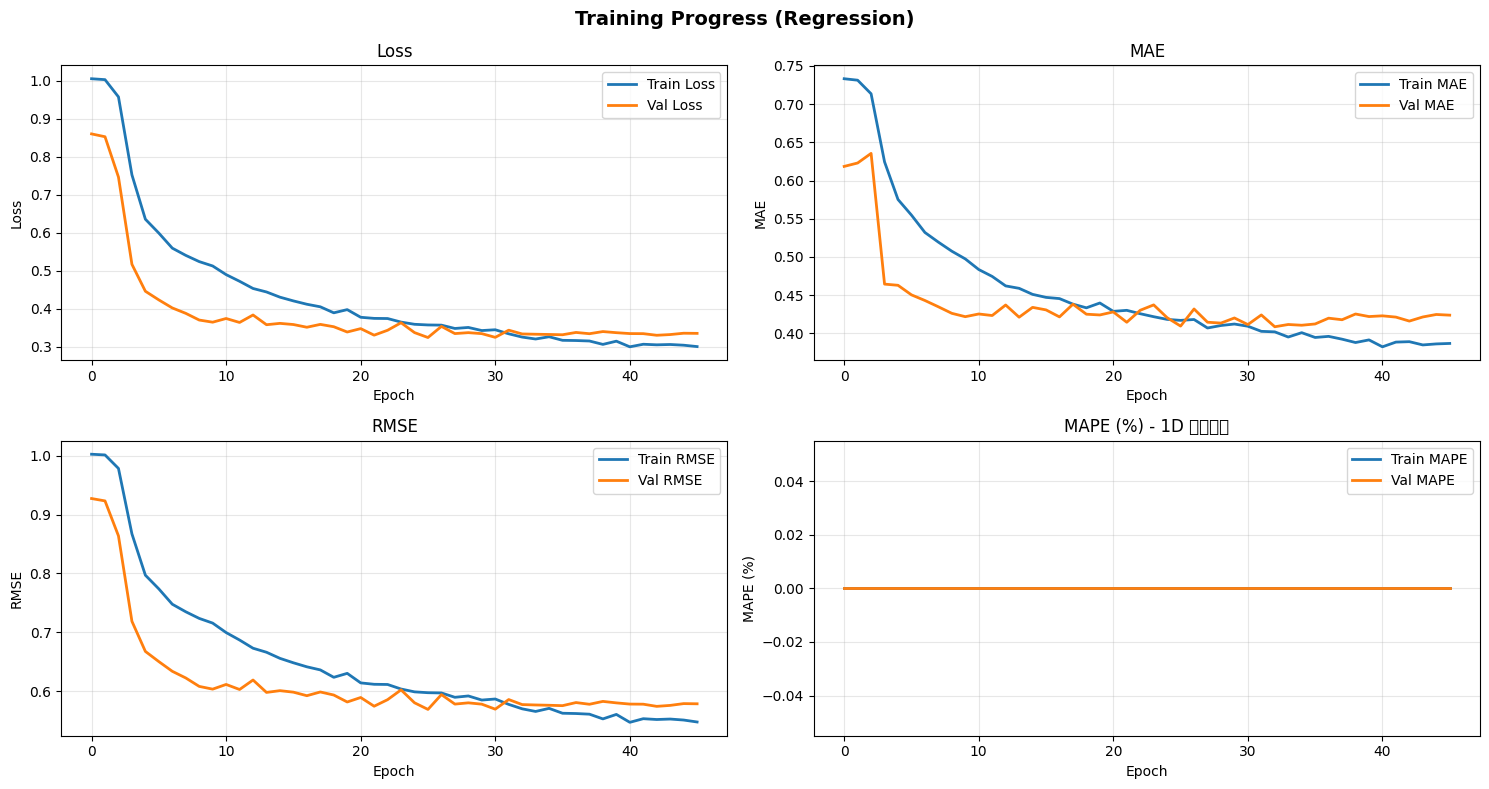

[Test]: 100%|██████████| 38/38 [00:00<00:00, 295.97it/s, loss=0.2971, mae=0.4802, rmse=0.5451]



=== 테스트 세트 평가(회귀) ===
Loss: 0.6394
MAE : 0.6239
RMSE: 0.7997
MAPE: 304.27%
R² (Output 1): 0.1937

✓ Predictions denormalized
  Original shape: (601, 1)
  Denormalized shape: (601, 1)

✓ Predictions saved to C:\project_WWTP\python\results\DL\flow_predictions.csv


(LSTMRegressor(
   (lstm): LSTM(31, 64, num_layers=3, batch_first=True, dropout=0.2)
   (attention): MultiheadAttention(
     (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
   )
   (head): Sequential(
     (0): Linear(in_features=64, out_features=128, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.2, inplace=False)
     (3): Linear(in_features=128, out_features=64, bias=True)
     (4): ReLU()
     (5): Dropout(p=0.2, inplace=False)
     (6): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 {'train_loss': [1.0049982228374281,
   1.0026036783814931,
   0.9571972170359447,
   0.7520077944402935,
   0.6351633433684581,
   0.5986027748644853,
   0.559026822613067,
   0.5399969587957157,
   0.5235782648284896,
   0.5120824516971572,
   0.4893149648744519,
   0.471756518578329,
   0.45281626006384856,
   0.44364982789304075,
   0.42995513884460224,
   0.4200991332581063,
   0.4113101888303997,
   0.40457791567600077,
   0.3887445720354048

In [90]:
main()